In [3]:
from akida_models.utk_face.preprocessing import load_data

# Load the dataset
x_train, y_train, x_test, y_test = load_data()

In [4]:
# For Akida inference, use uint8 raw data
x_test_akida = x_test.astype('uint8')

In [5]:
from akida_models import fetch_file
from tensorflow.keras.models import load_model

# Retrieve the model file from the BrainChip data server
model_file = fetch_file(fname="vgg_utk_face.h5",
                        origin="https://data.brainchip.com/models/AkidaV2/vgg/vgg_utk_face.h5",
                        cache_subdir='models')

# Load the native Keras pre-trained model
model_keras = load_model(model_file)
model_keras.summary()

Model: "vgg_utk_face"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv_0 (Conv2D)             (None, 30, 30, 32)        864       
                                                                 
 conv_0/BN (BatchNormalizati  (None, 30, 30, 32)       128       
 on)                                                             
                                                                 
 conv_0/relu (ReLU)          (None, 30, 30, 32)        0         
                                                                 
 conv_1 (Conv2D)             (None, 30, 30, 32)        9216      
                                                      

In [6]:
# Compile the native Keras model (required to evaluate the MAE)
model_keras.compile(optimizer='Adam', loss='mae')

# Check Keras model performance
mae_keras = model_keras.evaluate(x_test, y_test, verbose=0)

print("Keras MAE: {0:.4f}".format(mae_keras))

Keras MAE: 6.0806


In [7]:
from akida_models import vgg_utk_face_pretrained

# Load the pre-trained quantized model
model_quantized_keras = vgg_utk_face_pretrained()
model_quantized_keras.summary()

Model: "vgg_utk_face"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (QuantizedRescali  (None, 32, 32, 3)        0         
 ng)                                                             
                                                                 
 conv_0 (QuantizedConv2D)    (None, 30, 30, 32)        896       
                                                                 
 conv_0/relu (QuantizedReLU)  (None, 30, 30, 32)       64        
                                                                 
 conv_1 (QuantizedConv2D)    (None, 30, 30, 32)        9248      
                                                                 
 conv_1/maxpool (QuantizedMa  (None, 15, 15, 32)       0         
 xPool2D)                                             

In [8]:
# Compile the quantized Keras model (required to evaluate the MAE)
model_quantized_keras.compile(optimizer='Adam', loss='mae')

# Check Keras model performance
mae_quant = model_quantized_keras.evaluate(x_test, y_test, verbose=0)

print("Keras MAE: {0:.4f}".format(mae_quant))

Keras MAE: 5.8951


In [12]:
from cnn2snn import convert

# Convert the model
model_akida = convert(model_quantized_keras)
model_akida.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[32, 32, 3]  [1, 1, 1]     1          8     
______________________________________________

_________________________________________________________
Layer (type)               Output shape  Kernel shape  

============ SW/conv_0-dequantizer (Software) ===========

conv_0 (InputConv2D)       [30, 30, 32]  (3, 3, 3, 32) 
_________________________________________________________
conv_1 (Conv2D)            [15, 15, 32]  (3, 3, 32, 32)
_________________________________________________________
conv_2 (Conv2D)            [15, 15, 64]  (3, 3, 32, 64)
_________________________________________________________
conv_3 (Conv2D)            [8, 8, 64]    (3, 3, 64, 64)
_________________________________________________________
conv_4 (Conv2D)            [1, 1, 84]    (3, 3, 64, 84)
_________________________________________________________
dense_1 (Dense2D)       

In [13]:
import numpy as np

# Check Akida model performance
y_akida = model_akida.predict(x_test_akida)

# Compute and display the MAE
mae_akida = np.sum(np.abs(y_test.squeeze() - y_akida.squeeze())) / len(y_test)
print("Akida MAE: {0:.4f}".format(mae_akida))

# For non-regression purposes
assert abs(mae_keras - mae_akida) < 0.5

Akida MAE: 5.8951


In [14]:
import numpy as np

# Check Akida model performance
y_akida = model_akida.predict(x_test_akida)

# Compute and display the MAE
mae_akida = np.sum(np.abs(y_test.squeeze() - y_akida.squeeze())) / len(y_test)
print("Akida MAE: {0:.4f}".format(mae_akida))

# For non-regression purposes
assert abs(mae_keras - mae_akida) < 0.5

Akida MAE: 5.8951


1/1 [==============================] - 0s 161ms/step


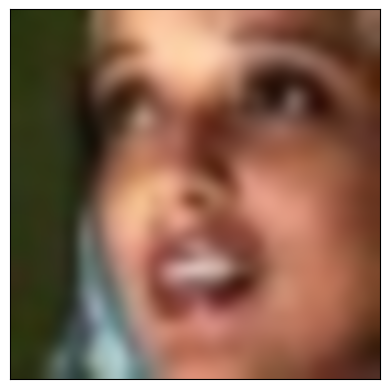

Keras estimated age: 28.2
Akida estimated age: 24.2
Actual age: 32


In [15]:
import matplotlib.pyplot as plt

# Estimate age on a random single image and display Keras and Akida outputs
id = np.random.randint(0, len(y_test) + 1)
age_keras = model_keras.predict(x_test[id:id + 1])

plt.imshow(x_test_akida[id], interpolation='bicubic')
plt.xticks([]), plt.yticks([])
plt.show()

print("Keras estimated age: {0:.1f}".format(age_keras.squeeze()))
print("Akida estimated age: {0:.1f}".format(y_akida[id].squeeze()))
print(f"Actual age: {y_test[id].squeeze()}")